In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

import matplotlib.pyplot as plt

# set gpu as default device
torch.set_default_device("cuda")

## Models

In [2]:
class RidgeRegressor(nn.Module):
    def __init__(self, noise_variance: float = 0.0):
        super().__init__()
        self.noise_variance = noise_variance

    def forward(self, X, y):
        n_samples, n_dim = X.shape
        ones = torch.ones(n_samples, 1, device=X.device)
        X = torch.concat([X, ones], dim=-1) # add bias

        if n_samples >= n_dim:
            # standard
            A = X.T@X
            A.diagonal().add_(self.noise_variance)
            B = X.T@y
            weights = torch.linalg.solve(A, B)
        else:
            # Woodbury
            A = X@X.T
            A.diagonal().add_(self.noise_variance)
            weights = X.T@torch.linalg.solve(A, y)
            
        w = weights[:-1].reshape(-1, 1)
        b = weights[-1].reshape(1, 1)

        return w, b # (n_dim, 1), (1, 1)

class SIREN(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, layers: list, activation_scale: float, dropout: float):
        super().__init__()

        self.activation_scale = activation_scale
        self.dropout = dropout

        self.input_layer = nn.Linear(input_dim, layers[0])
        self.layers = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.output_layer = nn.Linear(layers[-1], output_dim)

    def forward(self, x):
        out = self.input_layer(x)
        out = torch.sin(self.activation_scale * out)
        for layer in self.layers:
            out = layer(out)
            out = torch.sin(self.activation_scale * out)
            out = F.dropout(out, p=self.dropout, training=self.training)
        out = self.output_layer(out)
        return out

def get_initialized_model(input_dim, output_dim, layers, activation_scale, dropout):
    def first_layer_init(m):
        if hasattr(m, 'weight'):
            input_size = m.weight.size(-1)
            m.weight.uniform_(-1 / input_size, 1 / input_size)

    def other_layer_init(m):
        if hasattr(m, 'weight'):
            input_size = m.weight.size(-1)
            m.weight.uniform_(-np.sqrt(6 / input_size) / activation_scale, np.sqrt(6 / input_size) / activation_scale)

    model = SIREN(input_dim, output_dim, layers, activation_scale, dropout)
    with torch.no_grad():
        model.input_layer.apply(first_layer_init)
        model.layers.apply(other_layer_init)
        model.output_layer.apply(other_layer_init)

    return model

## Data generation

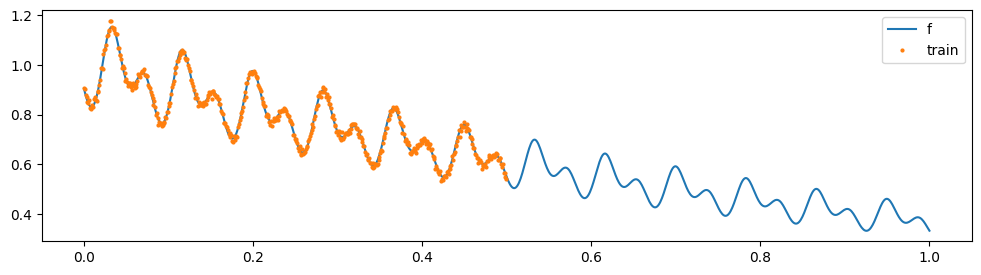

In [7]:
N = 1000
x = torch.linspace(0, 1, N).reshape(-1, 1)
f = lambda x: torch.exp(-(torch.sin(48 * np.pi * x) + torch.cos(24 * np.pi * x) + 10*x)/10)
# f = lambda x: x ** 2 
# f = lambda x: torch.log(x)
# a non-smooth degree 5 polynomial function
# f = lambda x: 0.01 * x ** 5 - 0.2 * x ** 3 - x + 0.5

x_train = x[:N//2]
noise_std = 0.01
y_train = f(x_train) + noise_std * torch.randn(N//2, 1)

x_test = x[N//2:]

plt.figure(figsize=(12, 3))
plt.plot(x.cpu(), f(x).cpu(), label='f');
plt.plot(x_train.cpu(), y_train.cpu(), 'o', label='train', markersize=2);
plt.legend();

## Data sequence preperation

In [8]:
lookback_window = 128
lookahead_window = 128
y_lookback = []
y_lookahead = []
for i in range(lookback_window, len(x_train)-lookahead_window+1):
    y_lookback.append(y_train[i-lookback_window:i][np.newaxis, ...])
    y_lookahead.append(y_train[i:i+lookahead_window][np.newaxis, ...])

y_lookback = torch.cat(y_lookback, dim=0)
y_lookahead = torch.cat(y_lookahead, dim=0)
print(f"{y_lookback.shape=}, \n{y_lookahead.shape=}") # [N, lookback_window, 1], [N, lookahead_window, 1]

y_lookback.shape=torch.Size([245, 128, 1]), 
y_lookahead.shape=torch.Size([245, 128, 1])


## Training

Loss: 0.0001: 100%|██████████| 500/500 [00:02<00:00, 212.82it/s]


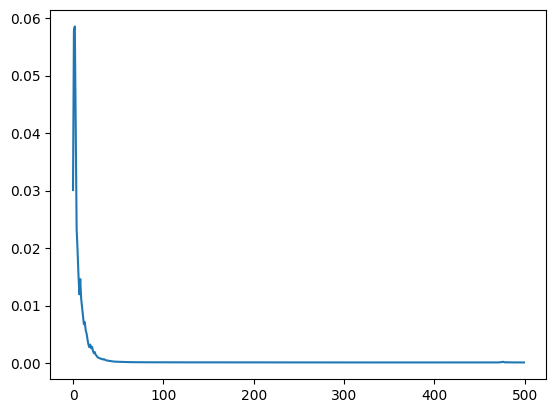

In [9]:
siren = get_initialized_model(1, 16, [256, 256], 30.0, 0.0)
ridge_reg = RidgeRegressor(noise_variance=1e-4)

def one_example_forward_pass(y_input, mode): # y_input: (lookback_window, 1), y_output: (lookahead_window, 1)
    if mode == "train":
        siren.train()
        ridge_reg.train()
    else:
        siren.eval()
        ridge_reg.eval()
        
    coords = torch.linspace(0, 1, lookback_window+lookahead_window).reshape(-1, 1)
    time_repr = siren(coords)
    lookback_repr = time_repr[:lookback_window]
    lookahead_repr = time_repr[-lookahead_window:]
    
    w, b = ridge_reg(lookback_repr, y_input)
    y_pred = lookahead_repr@w + b
    
    return y_pred
forward_pass = torch.vmap(one_example_forward_pass, in_dims=(0, None), out_dims=0, randomness="different")

optimizer = torch.optim.Adam(siren.parameters(), lr=1e-3)
epochs = 500

pbar = tqdm(range(epochs))
losses = []

for i in pbar:
    optimizer.zero_grad()
    y_lookahead_pred = forward_pass(y_lookback, "train")
    loss = F.mse_loss(y_lookahead_pred, y_lookahead)
    loss.backward()
    optimizer.step()
    pbar.set_description(f'Loss: {loss.item():.4f}')
    losses.append(loss.item())
    
plt.plot(losses)

## Testing

torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([1000, 1])
torch.Size([128, 1])


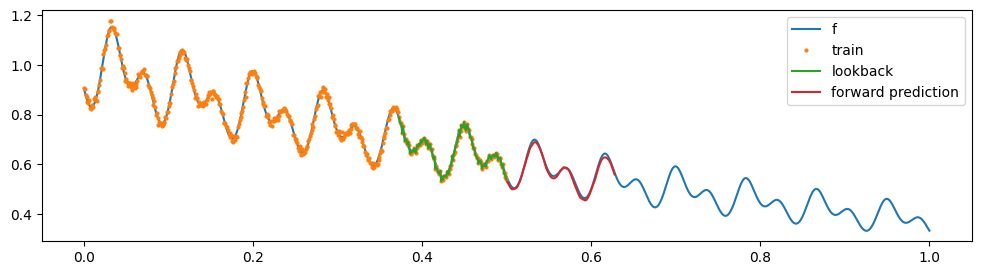

In [11]:
print(x_train.shape, y_train.shape, x.shape)
with torch.no_grad():
    y_pred = one_example_forward_pass(y_train[-lookback_window:], mode="test")
    print(y_pred.shape)

plt.figure(figsize=(12, 3))
plt.plot(x.cpu(), f(x).cpu(), label='f');
plt.plot(x_train.cpu(), y_train.cpu(), 'o', label='train', markersize=2);
plt.plot(x_train[-lookback_window:].cpu(), y_train[-lookback_window:].cpu(), label='lookback');
plt.plot(x_test.cpu()[:lookahead_window], y_pred.cpu(), label='forward prediction');
plt.legend();

## Appendix

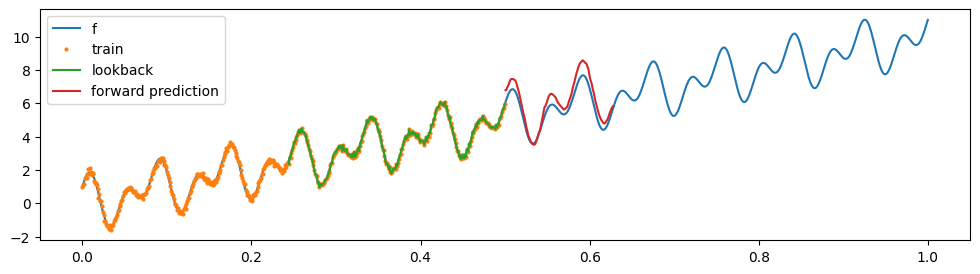

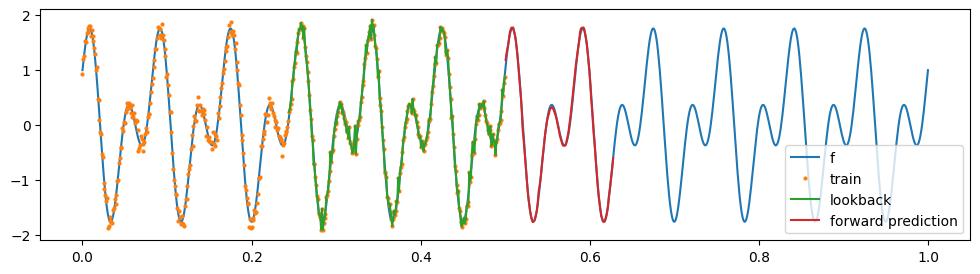

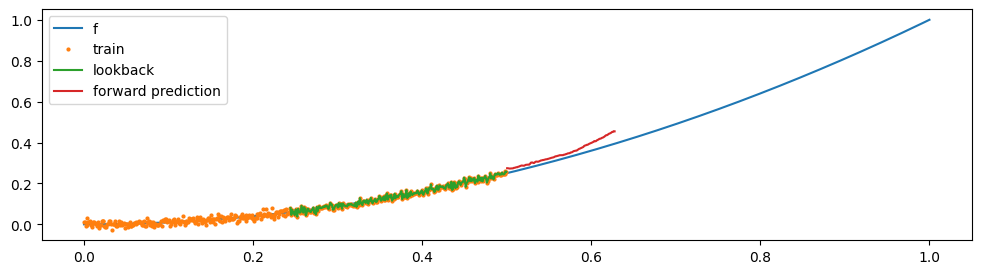

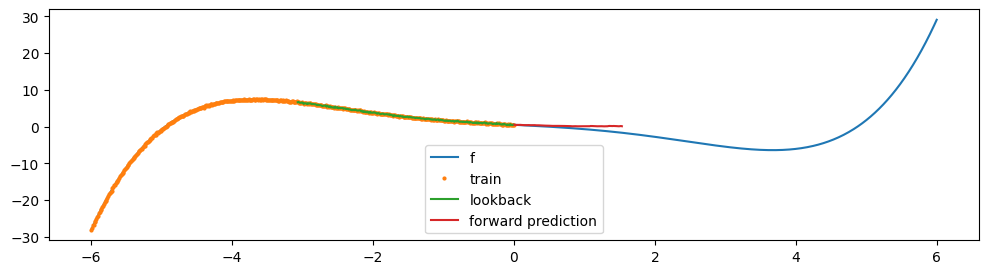